In [1]:
import numpy as np
import pandas as pd
import os, time
import itertools
from time import time

from pandas import read_csv, Series, DataFrame, concat
from pandas.tools.plotting import autocorrelation_plot

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA, ARMA, AR
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.metrics import mean_squared_error

import seaborn as sns
import matplotlib.pyplot as plt
%pylab inline

from matplotlib.pylab import rcParams
rcParams['font.family'] = 'Ubuntu'
rcParams['lines.linewidth'] = 2.5
rcParams['figure.figsize'] = 14, 4

/miniconda/envs/ts-env/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


Populating the interactive namespace from numpy and matplotlib


## Functions

In [2]:
## Exponential Time Smoothing

def run_in_R__ets(y=Series(), fh=int()):
    """
    Run ets in R on a pandas series
    """
    import rpy2.robjects as robjects
    from rpy2.robjects.packages import importr

    from rpy2.robjects import pandas2ri
    pandas2ri.activate()
    c=robjects.r('c')
    
    # convert ts to r object
    y_tr = y.iloc[:-fh]
    x = c(y_tr.values)
    
    # define the r function
    str_ets = """
    function(x){}
    library(forecast)
    y <- ts(x, frequency=7)
    fit_ets <- ets(y, model="ZZZ")
    yhat <- forecast(fit_ets, h={}, level=c(95))
    out_df <- data.frame(yhat$mean, yhat$lower, yhat$upper)
    out_df
    {}
    """.format("{", fh, "}")

    r_run = robjects.r(str_ets)
    result = r_run(x)
    
    df_predicted = pandas2ri.ri2py_dataframe(result).round(2)
    df_predicted.index = pd.date_range(start=y_tr.index[-1], periods=fh)
    df_predicted.columns = ['yhat', 'yhat_lower', 'yhat_upper']    
    df_predicted['y'] = y.iloc[-fh:]
    return df_predicted.dropna()

# df_predicted = run_in_R__ets(y=y, fh=20)

## TBATS

def run_in_R__tbats(y=Series(), fh=int()):
    """
    Run tbats in R on a pandas series
    """
    import rpy2.robjects as robjects
    from rpy2.robjects.packages import importr

    from rpy2.robjects import pandas2ri
    pandas2ri.activate()
    c=robjects.r('c')
    
    # convert ts to r object
    y_tr = y.iloc[:-fh]
    x = c(y_tr.values)
    
    # define the r function
    str_ets = """
    function(x){}
    library(forecast)
    y <- ts(x, frequency=7)
    y_tbats <- msts(y, seasonal.periods=7)
    fit_tbats <- tbats(y_tbats)
    yhat <- forecast(fit_tbats, h={}, level=c(95))
    out_df <- data.frame(yhat$mean, yhat$lower, yhat$upper)
    out_df
    {}
    """.format("{", fh, "}")

    r_run = robjects.r(str_ets)
    result = r_run(x)
    
    df_predicted = pandas2ri.ri2py_dataframe(result).round(2)
    df_predicted.index = pd.date_range(start=y_tr.index[-1], periods=fh)
    df_predicted.columns = ['yhat', 'yhat_lower', 'yhat_upper']
    
    df_predicted['y'] = y.iloc[-fh:]
    return df_predicted.dropna()

# df_predicted__tbats = run_in_R__tbats(y=y, fh=30)

## auto.arima
def run_in_R__autoARIMA(y=Series(), fh=int()):
    """
    Run auto.arima in R on a pandas series
    """
    import rpy2.robjects as robjects
    from rpy2.robjects.packages import importr

    from rpy2.robjects import pandas2ri
    pandas2ri.activate()
    c=robjects.r('c')
    
    # convert ts to r object
    y_tr = y.iloc[:-fh]
    x = c(y_tr.values)
    
    # define the r function
    str_ets = """
    function(x){}
    library(forecast)
    y <- ts(x, frequency=7)
    fit_auto_arima <- auto.arima(y, seasonal=TRUE)
    yhat <- forecast(fit_auto_arima, h={}, level=c(95))
    out_df <- data.frame(yhat$mean, yhat$lower, yhat$upper)
    out_df
    {}
    """.format("{", fh, "}")

    r_run = robjects.r(str_ets)
    result = r_run(x)
    
    df_predicted = pandas2ri.ri2py_dataframe(result).round(2)
    df_predicted.index = pd.date_range(start=y_tr.index[-1], periods=fh)
    df_predicted.columns = ['yhat', 'yhat_lower', 'yhat_upper']
    
    df_predicted['y'] = y.iloc[-fh:]
    return df_predicted.dropna()

In [3]:
def get_perf_metrics(df_predicted):
    """
    """
    y = df_predicted['y'].copy()
    yhat = df_predicted['yhat'].copy()
    
    mse = np.mean((y - yhat)**2)
    perc_err = (100*(y - yhat))/y
    
    return {'RMSE': np.sqrt(mse), 
            'MAPE': np.mean(abs(perc_err))}

In [4]:
def visualize_forecasts(y=Series(), df=DataFrame(), fh=int()):
    """
    """
    fig, ax = plt.subplots(figsize=(15, 5))
    
    y.to_frame(name='y').iloc[-fh * 3:, :].plot(ax=ax)
    ax_1 = df.drop('y', axis=1).plot(ax=ax, color=('r', 'k', 'k'), alpha=0.3)
    ax_1.fill_between(df.index, df['yhat_upper'], df['yhat_lower'], color='k', alpha=.2)

---
## Explore the time-series for trend, seasonality, outliers

/miniconda/envs/ts-env/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['Ubuntu'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


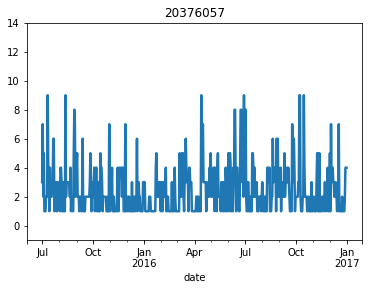

In [6]:
df_sales = pd.read_csv("../data/ts-data-few-missings.csv", parse_dates=['date']).set_index('date').loc['2015-07':]
df_holidays = pd.read_csv("../data/ts-holidays.csv", parse_dates=['date'])

ITEM = Series(df_sales.columns.tolist()).sample(1).iloc[0]
y = df_sales[ITEM].copy()

# clean
y.fillna(method='bfill', inplace=True)
y = y.clip_upper(y.quantile(0.99)).clip_lower(y.quantile(0.01))
y.dropna(inplace=True)

# visualize
y.plot(title=ITEM, ylim=(-1, y.max() + 5));

In [7]:
df_predicted_ets = run_in_R__ets(y=y.copy(), fh=30)

ImportError: libicuuc.so.58: cannot open shared object file: No such file or directory

In [14]:
!conda install -c 

    100% |████████████████████████████████| 194kB 1.5MB/s ta 0:00:01
  Running setup.py bdist_wheel for rpy2 ... error
  Complete output from command /miniconda/envs/ts-env/bin/python -u -c "import setuptools, tokenize;__file__='/tmp/pip-build-rqzsuqvp/rpy2/setup.py';f=getattr(tokenize, 'open', open)(__file__);code=f.read().replace('\r\n', '\n');f.close();exec(compile(code, __file__, 'exec'))" bdist_wheel -d /tmp/tmptz1mvzmlpip-wheel- --python-tag cp36:
  R version 3.3.2 (2016-10-31) -- "Sincere Pumpkin Patch"
  /miniconda/envs/ts-env/lib/R/bin/R CMD config --ldflags
  /miniconda/envs/ts-env/lib/R/bin/R CMD config --cppflags
  
      Compilation parameters for rpy2's C components:
          include_dirs    = ['/miniconda/envs/ts-env/lib/R/include']
          library_dirs    = ['/miniconda/envs/ts-env/lib/R/lib']
          libraries       = ['R', 'pcre', 'lzma', 'bz2', 'z', 'rt', 'dl', 'm', 'iconv', 'icuuc', 'icui18n']
          extra_link_args = ['-Wl,--export-dynamic', '-fopenmp']
  


Failed to build rpy2
  Running setup.py install for rpy2 ... error
    Complete output from command /miniconda/envs/ts-env/bin/python -u -c "import setuptools, tokenize;__file__='/tmp/pip-build-rqzsuqvp/rpy2/setup.py';f=getattr(tokenize, 'open', open)(__file__);code=f.read().replace('\r\n', '\n');f.close();exec(compile(code, __file__, 'exec'))" install --record /tmp/pip-5n8j7x3d-record/install-record.txt --single-version-externally-managed --compile:
    R version 3.3.2 (2016-10-31) -- "Sincere Pumpkin Patch"
    /miniconda/envs/ts-env/lib/R/bin/R CMD config --ldflags
    /miniconda/envs/ts-env/lib/R/bin/R CMD config --cppflags
    
        Compilation parameters for rpy2's C components:
            include_dirs    = ['/miniconda/envs/ts-env/lib/R/include']
            library_dirs    = ['/miniconda/envs/ts-env/lib/R/lib']
            libraries       = ['R', 'pcre', 'lzma', 'bz2', 'z', 'rt', 'dl', 'm', 'iconv', 'icuuc', 'icui18n']
            extra_link_args = ['-Wl,--export-dynamic', 

In [7]:
df_predicted_tbats = run_in_R__tbats(y=y.copy(), fh=30)

In [8]:
df_predicted_aa = run_in_R__autoARIMA(y=y.copy(), fh=30)

## Metrics

In [16]:
get_perf_metrics(df_predicted_aa)

{'MAPE': 76.273809523809518, 'RMSE': 1.6367535150307506}

In [12]:
get_perf_metrics(df_predicted_tbats)

{'MAPE': 57.396551724137929, 'RMSE': 1.7830050186557873}

In [13]:
get_perf_metrics(df_predicted_ets)

{'MAPE': 68.33292282430213, 'RMSE': 1.7821219432714626}

## Visualize

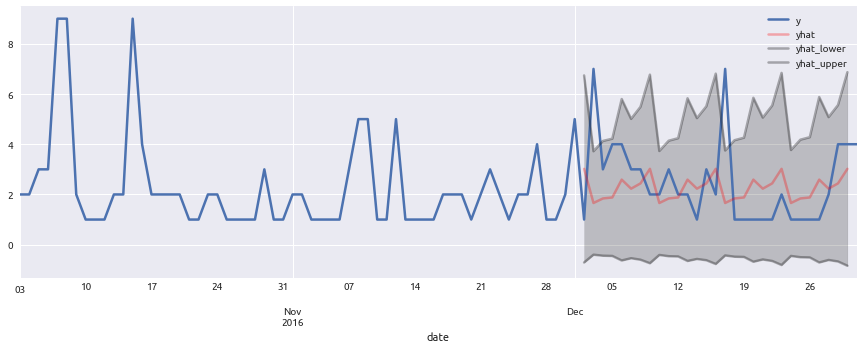

In [17]:
visualize_forecasts(y=y.copy(), df=df_predicted_ets, fh=30)